Load Data

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
file_train = "/content/drive/My Drive/Colab Notebooks/num_train_data.csv"
file_test = "/content/drive/My Drive/Colab Notebooks/num_test_data.csv"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd

train = pd.read_csv(file_train)
test = pd.read_csv(file_test)

Prep Data

In [ ]:
def prep_data(data):
  data['Z'] = [1] * len(data)
  data['cluster'] = data['id'].str.replace(' _', '').astype(int)
  X = data[data.columns.difference(['job_satisfaction', 'id', 'Z', 'cluster', 'Unnamed: 0', 'employer_id'])]
  Z = data[['Z']]
  clusters = data['cluster']
  y = data['job_satisfaction']
  return X, Z, clusters, y

In [ ]:
X_train, Z_train, clusters_train, y_train = prep_data(train)
X_test, Z_test, clusters_test, y_test = prep_data(test)

MERF

In [ ]:
!pip install -q merf

In [ ]:
from merf import MERF

# modeling
mrf = MERF(max_iterations=5)
mrf.fit(X_train, Z_train, clusters_train, y_train)

INFO     [utils.py:141] NumExpr defaulting to 2 threads.
INFO     [merf.py:307] Training GLL is -378.7581477354253 at iteration 1.
INFO     [merf.py:307] Training GLL is 731.9603476296201 at iteration 2.
INFO     [merf.py:307] Training GLL is 1424.7073857805942 at iteration 3.
INFO     [merf.py:307] Training GLL is 1809.1717452321643 at iteration 4.
INFO     [merf.py:307] Training GLL is 2135.112174766458 at iteration 5.


In [ ]:
# prediction
y_pred = mrf.predict(X_test, Z_test, clusters_test)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, y_pred))
rms

2.1981327579683136

SHAP

In [ ]:
!pip install -q shap

     |████████████████████████████████| 276kB 2.8MB/s 


In [ ]:
# reshuffle so not taking just a few participants off top
X_train = X_train.sample(frac = 1, random_state=123)

In [ ]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.TreeExplainer(mrf.trained_fe_model, X_train[:100])

In [ ]:
# shap values
shap_values = explainer.shap_values(X_test, check_additivity=False)

100%|===================| 4333/4334 [29:49<00:00]       

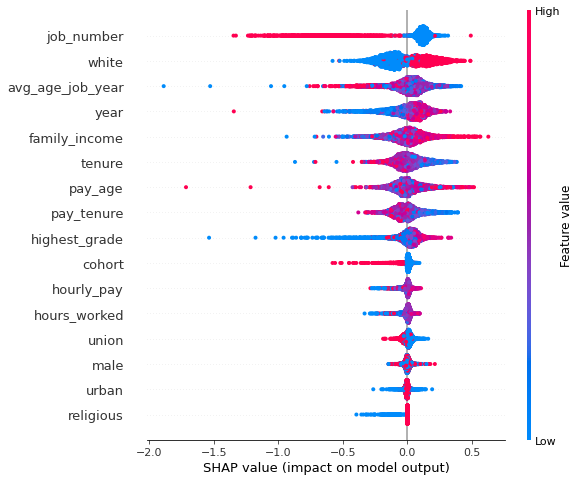

In [ ]:
shap.summary_plot(shap_values, X_test)

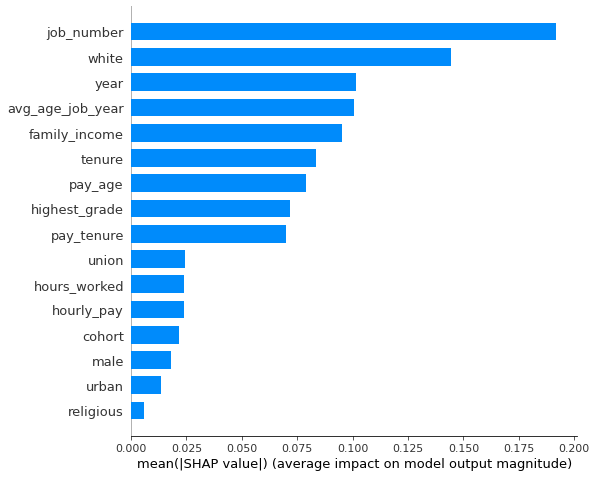

In [ ]:
# feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

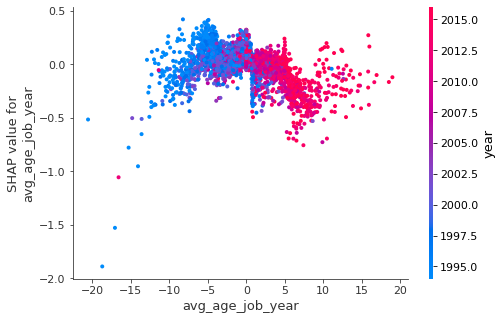

In [ ]:
# dependence plots
# https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html

shap.dependence_plot("avg_age_job_year", shap_values, X_test, interaction_index="year")

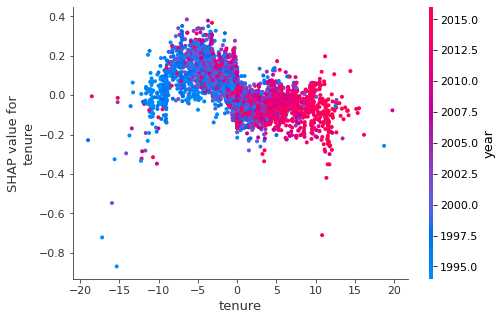

In [ ]:
shap.dependence_plot("tenure", shap_values, X_test, interaction_index="year")

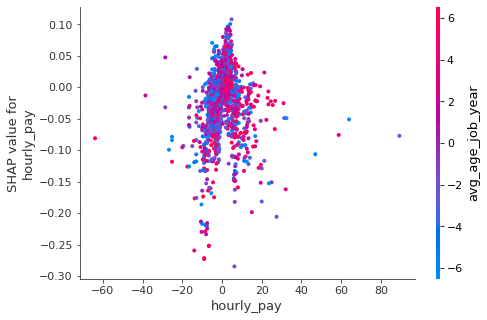

In [ ]:
shap.dependence_plot("hourly_pay", shap_values, X_test, interaction_index="avg_age_job_year")

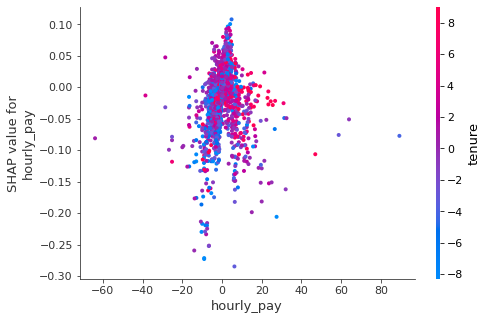

In [ ]:
shap.dependence_plot("hourly_pay", shap_values, X_test, interaction_index="tenure")

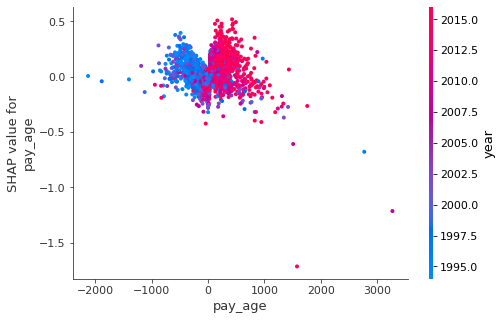

In [ ]:
shap.dependence_plot("pay_age", shap_values, X_test, interaction_index="year")

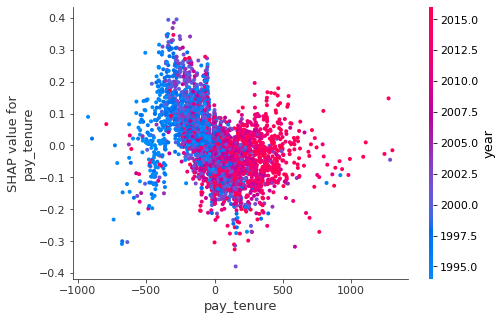

In [ ]:
shap.dependence_plot("pay_tenure", shap_values, X_test, interaction_index="year")

In [ ]:
# most average people
X_test.describe()

,avg_age_job_year,cohort,family_income,highest_grade,hourly_pay,hours_worked,job_number,male,pay_age,pay_tenure,religious,tenure,union,urban,white,year
count,4.334000e+03,4334.000000,4.334000e+03,4334.000000,4.334000e+03,4.334000e+03,4334.000000,4334.000000,4.334000e+03,4.334000e+03,4334.000000,4.334000e+03,4334.000000,4334.000000,4334.000000,4334.000000
mean,-1.864888e-16,1981.803415,-1.099874e-15,14.452238,7.377578e-17,7.377578e-17,1.189432,0.454315,5.042984e-15,-2.126382e-15,0.963313,-1.347945e-16,0.385095,0.781957,0.433087,2004.746424
std,4.004741e+00,6.527799,1.515320e+00,3.875027,4.517945e+00,4.517945e+00,0.521293,0.497966,2.509389e+02,2.169829e+02,0.188013,4.743134e+00,0.486674,0.412965,0.495560,7.158009
min,-2.055641e+01,1979.000000,-1.091737e+01,3.000000,-6.400000e+01,-6.400000e+01,1.000000,0.000000,-2.132146e+03,-9.251422e+02,0.000000,-1.899359e+01,0.000000,0.000000,0.000000,1979.000000
25%,-2.166096e+00,1979.000000,-2.887207e-01,12.000000,-7.644231e-01,-7.644231e-01,1.000000,0.000000,-1.180203e+02,-1.069511e+02,1.000000,-2.509615e+00,0.000000,1.000000,0.000000,1998.000000
50%,0.000000e+00,1979.000000,2.488426e-01,14.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000,1.000000,0.000000,2004.000000
75%,2.091528e+00,1979.000000,6.713190e-01,16.000000,0.000000e+00,0.000000e+00,1.000000,1.000000,9.577094e+01,8.338986e+01,1.000000,2.141071e+00,1.000000,1.000000,1.000000,2011.000000
max,1.898339e+01,1997.000000,3.265012e+00,95.000000,8.940000e+01,8.940000e+01,9.000000,1.000000,3.274546e+03,1.300905e+03,1.000000,1.975962e+01,1.000000,1.000000,1.000000,2017.000000


In [ ]:
avg_people = test.loc[(test['highest_grade'] == 14) & 
                      ((test['family_income'] > -0.5) & (test['family_income'] < 0.5)) &
                      (test['male'] == 0) &
                      (test['white'] == 0) &
                      (test['religious'] == 1) &
                      (test['urban'] == 1)]

In [ ]:
avg_indices = avg_people.drop_duplicates(subset='id', keep='first').index.tolist()

In [ ]:
shap.initjs()

# explainer.expected_value = mean job satisfaction
# shap_values for each feature of each row of X_test
# X_test row to explain

for i in avg_indices:
  display(shap.force_plot(explainer.expected_value, shap_values[i], X_test[i:i+1]))